In [1]:
import xarray as xr
# import xesmf as xe
import numpy as np
from numpy import s_
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import os
from collections import defaultdict
import metpy.calc as mpcalc
from metpy.units import units
from datetime import datetime
import pandas as pd
import dask as da
import pytz
import string


In [2]:
import matplotlib as mpl
mpl.rcParams.update({
    'axes.titlesize': 20,        # Title font size
    'axes.labelsize': 15,        # Axis label font size
    'xtick.labelsize': 12,       # X-axis tick label font size
    'ytick.labelsize': 12,       # Y-axis tick label font size
    'legend.fontsize': 12,       # Legend font size
    'figure.titlesize': 20,      # Figure suptitle font size
})

In [4]:
from dask.distributed import Client
client = Client(threads_per_worker=1,memory_limit=0,n_workers=28) # n_workers= number of cores
client.amm.start()
# warnings.simplefilter(action='ignore', category=FutureWarning)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44231 instead
  warnings.warn(


In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44231/status,
Dashboard: /proxy/44231/status,Workers: 28
Total threads: 28,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36193,Workers: 0
Dashboard: /proxy/44231/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45803,Total threads: 1
Dashboard: /proxy/40263/status,Memory: 0 B
Nanny: tcp://127.0.0.1:46091,


# Functions to calculate equivalent potential temperature

In [6]:
def UTC_to_LST(ds, timezone): # longitude
    ds = ds.copy()
    # Convert to pandas datetime in UTC
    time_objects_utc = pd.to_datetime(ds['time'].values).tz_localize('UTC')
    
    # Convert to local standard time using pytz
    local_timezone = pytz.timezone(timezone)
    time_objects_local = time_objects_utc.tz_convert(local_timezone).tz_localize(None)

    ds['time'] = time_objects_local#.tz_localize(None)
    return ds

def list_variable_file_paths(variable: str) -> list[str]:
    """Function to return a list of file paths (str) of BARRA-2 netcdf4 variable files

    Args:
        variable (str): The BoM variable name. The BARRA-2 list of variable names can be found at http://www.bom.gov.au/research/publications/researchreports/BRR-067.pdf (Chun-Hsu Su et al., 2022).  e.g. ta200 (temperature at 200 hPa) and hus950 (specific humidity at 950 hPa)

    Returns:
        list[str]: File paths to variable
    """
    # This list of month strings is used to only look at data for time periods with associated radar data (2012-2022)
    list = ["202201-202201","202202-202202","202101-202101","202102-202102","202103-202103","202104-202104","202001-202001","202002-202002",
           "202003-202003","202004-202004","201901-201901","201902-201902","201903-201903","201904-201904","201801-201801","201802-201802",
           "201803-201803","201804-201804","201701-201701","201702-201702","201703-201703","201704-201704","201601-201601","201602-201602",
           "201603-201603","201604-201604","201501-201501","201502-201502","201503-201503","201504-201504","201401-201401","201402-201402",
           "201403-201403","201404-201404","201301-201301","201302-201302","201303-201303","201304-201304","201201-201201","201202-201202",
           "201203-201203","201204-201204"]
    list.sort()
    file_paths = []
    for i in list:
        fp = "/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/"+variable+"/v20240516/" # the version name periodicly updates
        all_files = [fp+variable+"_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_1hr_"+i+".nc"]
        file_paths.extend(all_files)
    file_paths.sort()
    return file_paths  


def open_and_combine_variable(file_paths: list[str],variable_sel1: int,variable_sel2: int) -> {xr.Dataset,xr.Dataset,xr.Dataset}:
    """Function to open netcdf4 files for a BARRA-2 variable, select a single lat-lon point, and combine values along every pressure level into a single dataset for Townsville, Cairns and Willis Island locations.

    Args:
        file_paths (list[str]): File paths generated from: list_variable_file_paths function
        variable_sel1 (int): Extract the BoM BARRA-2 variable string from the file path e.g. for temp, =102, hus =103
        variable_sel2 (int): Extract the BoM BARRA-2 variable string from the file path e.g. for temp, =107, hus = 109

    Returns:
        xr.Dataset,xr.Dataset,xr.Dataset: {Townsville, Cairns, Willis Island} BARRA-2 dataset for a variable over every pressure level
    """
    datasets_towns=[]
    datasets_cairns=[]
    datasets_willis=[]
    for fp in file_paths:
        with xr.open_mfdataset(fp, engine="h5netcdf", chunks="auto") as ds:
            # select coordinates closest to radar sites & drop the pressure variable (conflicting)
            towns = ds.sel(lat=-19.4198,lon=146.5509,method="nearest").drop_vars('pressure')
            cairns = ds.sel(lat=-16.817,lon=145.683,method="nearest").drop_vars('pressure')
            willis = ds.sel(lat=-16.2874,lon=149.9646,method="nearest").drop_vars('pressure')

            # Extract variable name in filepath string
            towns = towns[fp[0][variable_sel1:variable_sel2]]
            cairns = cairns[fp[0][variable_sel1:variable_sel2]]
            willis = willis[fp[0][variable_sel1:variable_sel2]]
            
            datasets_towns.append(towns)
            datasets_cairns.append(cairns)
            datasets_willis.append(willis)
            ds.close()

    # combine result for each pressure level into one array
    combine_towns = xr.combine_by_coords(datasets_towns)
    combine_cairns = xr.combine_by_coords(datasets_cairns)
    combine_willis = xr.combine_by_coords(datasets_willis)
    return combine_towns,combine_cairns,combine_willis


def calc_eqpt(p: np.array, t: np.array, q: np.array) -> np.ndarray:
    """Calculates equivalent potential temperature in [K] from pressure [Pa], temperature [K] and specific humidity [kg/kg].

    Args:
        p (np.array): pressure in [Pa]
        t (np.array): temperature in [K]
        q (np.array): specific humidity in [kg/kg]
    p, t and q can be scalars or np arrays.

    Returns: 
        Equivalent potential temperature in [K].
    """
    return mpcalc.equivalent_potential_temperature(units.Pa * p, units.K * t,mpcalc.dewpoint_from_specific_humidity(units.Pa * p, units.K * t, q)).to("K").m


def calculate_single_hour_mean(hour: int, wind_dir: xr.DataArray, ds: xr.Dataset):
    """A delayed function for the calculation of a single hour (between 0-24) for mean values of temperature and specific humidity.
    Args:
        hour (int): Integer between 0-24
        wind_dir (xr.DataArray): Wind direction (degrees) 
        ds (xr.Dataset): Dataset produced by: open_and_combine_variable

    Returns:
        da.delayed: A delayed array of mean (over time) values
    """
    wind_times_hour = wind_dir.groupby(wind_dir.time.dt.hour == hour)
    wind_result = wind_times_hour[1].time.values
    ds_regime = ds.sel(time=wind_result)
    mean_values_lazy = da.delayed(ds_regime.drop_vars(["lon", "lat"]).mean(dim='time'))
    return mean_values_lazy


def variable_hourly_mean_values(barra_ds: xr.Dataset,deg1: int,deg2: int,barra_variable_ds: xr.Dataset,ne: bool=False,all_winds: bool=False) -> np.ndarray:
    """Function to compute hourly mean values of temperature and specific humidity (which can then be used to calculate av. hourly mean eqpt). 

    Args:
        barra_ds (xr.Dataset): The wind regime dataset to apply (Townsville, Cairns or Willis Island)
        deg1 (int): Wind direction in degrees start of slice
        deg2 (int): Wind direction in degrees end of slice
        barra_variable_ds (xr.Dataset): Which BARRA-2 variable dataset to calculate mean values of i.e. temperature or specific humidity e.g. ta_towns
        ne (bool, optional): If True wind direction start slice >=0 degrees. Defaults to False.
        all_winds (bool, optional): If True all time periods are analysed (climatological means). Defaults to False.

    Returns:
        np.ndarray: Array of hourly mean values for a given BARRA-2 variable
    """
    winds = barra_ds.wind_dir.compute()
    if ne:
        winds_dir = winds[(winds>=deg1)&(winds<=deg2)]
    else:
        winds_dir = winds[(winds>deg1)&(winds<=deg2)]
    if all_winds:
        winds_dir = winds
    else:
        pass
    mean_values = []
    # use defined function to calc mean
    for hour in np.arange(0, 24, 1):
        mean_values.append(calculate_single_hour_mean(hour, winds_dir, barra_variable_ds)) 
    return da.compute(mean_values, scheduler='processes')[0]


def extract_mean_values(mean_result: np.ndarray) -> np.ndarray:
    """Function to create hourly mean values and return as an array.

    Args:
        mean_result (np.ndarray): Results from function: variable_hourly_mean_values

    Returns:
        np.ndarray: Mean values in UTC
    """
    values_UTC = []
    for hour in np.arange(0,24,1):
        mean_values_array = mean_result[hour]
        var_names = list(mean_values_array.data_vars.keys())
        result = [mean_values_array[var].values for var in reversed(var_names)]
        values_UTC.append(result)
    return values_UTC

# Plot mean and anomalies

In [7]:
barra_towns = xr.open_dataset("/g/data/q90/ac9768/GBR/barra-2/barra-2_850hPa-winds_towns.nc", engine="h5netcdf",chunks="auto").sel(time=slice('1979-01-01T00:00:00.000000000','2023-05-01T00:00:00.000000000'))
barra_cairns = xr.open_dataset("/g/data/q90/ac9768/GBR/barra-2/barra-2_850hPa-winds_cairns.nc", engine="h5netcdf",chunks="auto").sel(time=slice('1979-01-01T00:00:00.000000000','2023-05-01T00:00:00.000000000'))
barra_willis = xr.open_dataset("/g/data/q90/ac9768/GBR/barra-2/barra-2_850hPa-winds_willis.nc", engine="h5netcdf",chunks="auto").sel(time=slice('1979-01-01T00:00:00.000000000','2023-05-01T00:00:00.000000000'))
barra_towns_eqpt = xr.open_dataset('/g/data/q90/ac9768/GBR/barra-2/barra-2_eqpt-ds_towns.nc').sel(time=slice('1979-01-01T00:00:00.000000000','2023-05-01T00:00:00.000000000'))
barra_cairns_eqpt = xr.open_dataset('/g/data/q90/ac9768/GBR/barra-2/barra-2_eqpt-ds_cairns.nc').sel(time=slice('1979-01-01T00:00:00.000000000','2023-05-01T00:00:00.000000000'))
barra_willis_eqpt = xr.open_dataset('/g/data/q90/ac9768/GBR/barra-2/barra-2_eqpt-ds_willis.nc').sel(time=slice('1979-01-01T00:00:00.000000000','2023-05-01T00:00:00.000000000'))

In [8]:
def wind_times(barra_regime_ds: xr.Dataset):    
    winds = barra_regime_ds.wind_dir.compute()
    ne = winds[(winds>=0)&(winds<=90)].time.values
    se = winds[(winds>90)&(winds<=180)].time.values
    sw = winds[(winds>180)&(winds<=270)].time.values
    nw = winds[(winds>270)&(winds<=360)].time.values
    return ne,se,sw,nw
ne_towns,se_towns,sw_towns,nw_towns = wind_times(barra_towns)
ne_cairns,se_cairns,sw_cairns,nw_cairns = wind_times(barra_cairns)
ne_willis,se_willis,sw_willis,nw_willis = wind_times(barra_willis)

In [9]:
site = {
    'towns' : {
        'eqpt': UTC_to_LST(barra_towns_eqpt.eqpt,'Australia/Sydney').mean('time'),
        'eqpt25':UTC_to_LST(barra_towns_eqpt.eqpt,'Australia/Sydney').quantile(0.25,dim='time'),
        'eqpt75':UTC_to_LST(barra_towns_eqpt.eqpt,'Australia/Sydney').quantile(0.75,dim='time'),
      
        'eqptNE': UTC_to_LST(barra_towns_eqpt.eqpt.sel(time=ne_towns),'Australia/Sydney').mean('time'),
        'eqpt25NE':UTC_to_LST(barra_towns_eqpt.eqpt.sel(time=ne_towns),'Australia/Sydney').quantile(0.25,dim='time'),
        'eqpt75NE':UTC_to_LST(barra_towns_eqpt.eqpt.sel(time=ne_towns),'Australia/Sydney').quantile(0.75,dim='time'),
        'nNE':len(UTC_to_LST(barra_towns_eqpt.eqpt.sel(time=ne_towns),'Australia/Sydney').values[0])*9,
        
        'eqptSE': UTC_to_LST(barra_towns_eqpt.eqpt.sel(time=se_towns),'Australia/Sydney').mean('time'),
        'eqpt25SE':UTC_to_LST(barra_towns_eqpt.eqpt.sel(time=se_towns),'Australia/Sydney').quantile(0.25,dim='time'),
        'eqpt75SE':UTC_to_LST(barra_towns_eqpt.eqpt.sel(time=se_towns),'Australia/Sydney').quantile(0.75,dim='time'),
        'nSE':len(UTC_to_LST(barra_towns_eqpt.eqpt.sel(time=se_towns),'Australia/Sydney').values[0])*9,
    
        'eqptSW': UTC_to_LST(barra_towns_eqpt.eqpt.sel(time=sw_towns),'Australia/Sydney').mean('time'),
        'eqpt25SW':UTC_to_LST(barra_towns_eqpt.eqpt.sel(time=sw_towns),'Australia/Sydney').quantile(0.25,dim='time'),
        'eqpt75SW':UTC_to_LST(barra_towns_eqpt.eqpt.sel(time=sw_towns),'Australia/Sydney').quantile(0.75,dim='time'),
        'nSW':len(UTC_to_LST(barra_towns_eqpt.eqpt.sel(time=sw_towns),'Australia/Sydney').values[0])*9,

        'eqptNW': UTC_to_LST(barra_towns_eqpt.eqpt.sel(time=nw_towns),'Australia/Sydney').mean('time'),
        'eqpt25NW':UTC_to_LST(barra_towns_eqpt.eqpt.sel(time=nw_towns),'Australia/Sydney').quantile(0.25,dim='time'),
        'eqpt75NW':UTC_to_LST(barra_towns_eqpt.eqpt.sel(time=nw_towns),'Australia/Sydney').quantile(0.75,dim='time'),
        'nNW':len(UTC_to_LST(barra_towns_eqpt.eqpt.sel(time=nw_towns),'Australia/Sydney').values[0])*9,
    },

    'cairns' : {
        'eqpt': UTC_to_LST(barra_cairns_eqpt.eqpt,'Australia/Sydney').mean('time'),
        'eqpt25':UTC_to_LST(barra_cairns_eqpt.eqpt,'Australia/Sydney').quantile(0.25,dim='time'),
        'eqpt75':UTC_to_LST(barra_cairns_eqpt.eqpt,'Australia/Sydney').quantile(0.75,dim='time'),
        
        'eqptNE': UTC_to_LST(barra_cairns_eqpt.eqpt.sel(time=ne_cairns),'Australia/Sydney').mean('time'),
         'eqpt25NE':UTC_to_LST(barra_cairns_eqpt.eqpt.sel(time=ne_cairns),'Australia/Sydney').quantile(0.25,dim='time'),
        'eqpt75NE':UTC_to_LST(barra_cairns_eqpt.eqpt.sel(time=ne_cairns),'Australia/Sydney').quantile(0.75,dim='time'),
        'nNE':len(UTC_to_LST(barra_cairns_eqpt.eqpt.sel(time=ne_cairns),'Australia/Sydney').values[0])*9,
        
        'eqptSE': UTC_to_LST(barra_cairns_eqpt.eqpt.sel(time=se_cairns),'Australia/Sydney').mean('time'),
         'eqpt25SE':UTC_to_LST(barra_cairns_eqpt.eqpt.sel(time=se_cairns),'Australia/Sydney').quantile(0.25,dim='time'),
        'eqpt75SE':UTC_to_LST(barra_cairns_eqpt.eqpt.sel(time=se_cairns),'Australia/Sydney').quantile(0.75,dim='time'),
        'nSE':len(UTC_to_LST(barra_cairns_eqpt.eqpt.sel(time=se_cairns),'Australia/Sydney').values[0])*9,
        
        'eqptSW': UTC_to_LST(barra_cairns_eqpt.eqpt.sel(time=sw_cairns),'Australia/Sydney').mean('time'),
        'eqpt25SW':UTC_to_LST(barra_cairns_eqpt.eqpt.sel(time=sw_cairns),'Australia/Sydney').quantile(0.25,dim='time'),
        'eqpt75SW':UTC_to_LST(barra_cairns_eqpt.eqpt.sel(time=sw_cairns),'Australia/Sydney').quantile(0.75,dim='time'),
        'nSW':len(UTC_to_LST(barra_cairns_eqpt.eqpt.sel(time=sw_cairns),'Australia/Sydney').values[0])*9,
        
        'eqptNW': UTC_to_LST(barra_cairns_eqpt.eqpt.sel(time=nw_cairns),'Australia/Sydney').mean('time'),
        'eqpt25NW':UTC_to_LST(barra_cairns_eqpt.eqpt.sel(time=nw_cairns),'Australia/Sydney').quantile(0.25,dim='time'),
        'eqpt75NW':UTC_to_LST(barra_cairns_eqpt.eqpt.sel(time=nw_cairns),'Australia/Sydney').quantile(0.75,dim='time'),
        'nNW':len(UTC_to_LST(barra_cairns_eqpt.eqpt.sel(time=nw_cairns),'Australia/Sydney').values[0])*9,
    },

    'willis' : {
        'eqpt': UTC_to_LST(barra_willis_eqpt.eqpt,'Australia/Sydney').mean('time'),
        'eqpt25':UTC_to_LST(barra_willis_eqpt.eqpt,'Australia/Sydney').quantile(0.25,dim='time'),
        'eqpt75':UTC_to_LST(barra_willis_eqpt.eqpt,'Australia/Sydney').quantile(0.75,dim='time'),
        
        'eqptNE': UTC_to_LST(barra_willis_eqpt.eqpt.sel(time=ne_willis),'Australia/Sydney').mean('time'),
        'eqpt25NE':UTC_to_LST(barra_willis_eqpt.eqpt.sel(time=ne_willis),'Australia/Sydney').quantile(0.25,dim='time'),
        'eqpt75NE':UTC_to_LST(barra_willis_eqpt.eqpt.sel(time=ne_willis),'Australia/Sydney').quantile(0.75,dim='time'),
        'nNE':len(UTC_to_LST(barra_willis_eqpt.eqpt.sel(time=ne_willis),'Australia/Sydney').values[0])*9,
        
        'eqptSE': UTC_to_LST(barra_willis_eqpt.eqpt.sel(time=se_willis),'Australia/Sydney').mean('time'),
          'eqpt25SE':UTC_to_LST(barra_willis_eqpt.eqpt.sel(time=se_willis),'Australia/Sydney').quantile(0.25,dim='time'),
        'eqpt75SE':UTC_to_LST(barra_willis_eqpt.eqpt.sel(time=se_willis),'Australia/Sydney').quantile(0.75,dim='time'),
        'nSE':len(UTC_to_LST(barra_willis_eqpt.eqpt.sel(time=se_willis),'Australia/Sydney').values[0])*9,
        
        'eqptSW': UTC_to_LST(barra_willis_eqpt.eqpt.sel(time=sw_willis),'Australia/Sydney').mean('time'),
        'eqpt25SW':UTC_to_LST(barra_willis_eqpt.eqpt.sel(time=sw_willis),'Australia/Sydney').quantile(0.25,dim='time'),
        'eqpt75SW':UTC_to_LST(barra_willis_eqpt.eqpt.sel(time=sw_willis),'Australia/Sydney').quantile(0.75,dim='time'),
        'nSW':len(UTC_to_LST(barra_willis_eqpt.eqpt.sel(time=sw_willis),'Australia/Sydney').values[0])*9,
        
        'eqptNW': UTC_to_LST(barra_willis_eqpt.eqpt.sel(time=nw_willis),'Australia/Sydney').mean('time'),
         'eqpt25NW':UTC_to_LST(barra_willis_eqpt.eqpt.sel(time=nw_willis),'Australia/Sydney').quantile(0.25,dim='time'),
        'eqpt75NW':UTC_to_LST(barra_willis_eqpt.eqpt.sel(time=nw_willis),'Australia/Sydney').quantile(0.75,dim='time'),
        'nNW':len(UTC_to_LST(barra_willis_eqpt.eqpt.sel(time=nw_willis),'Australia/Sydney').values[0])*9,
    }
}

In [14]:
def plot_eqpt_mean_anomalies(site: dict, plot_samples: bool = True, mean_qnt: bool = True, regime_qnt: bool = False, legend: bool=False) -> None:
    """Plot mean and anomaly profiles of equivalent potential temperature (θₑ).

    Args:
        site (dict): Dictionary with climatology and regime θₑ values per pressure level/hour.
        title (str): Plot title (e.g., site name).
    """
    sns.set_style("ticks") #, {'axes.grid': True})    
    fig, ax = plt.subplots(3, 2, figsize=[12, 12])
    pressure = np.array([950, 925, 850, 700, 600, 500, 400, 300, 200])
    
    regimes = {
        "NE": "seagreen",
        "SE": "royalblue",
        "SW": "purple",
        "NW": "orange"
    }
    site_titles = {
        "towns": "Townsville",
        "cairns": "Cairns",
        "willis": "Willis Island"
    }

    # ax in 2D
    ax = ax.reshape(3, 2)
    for row, (location, data) in enumerate(site.items()):
        clim_mean = site[location]["eqpt"]
        
        # Plot mean profiles        
        mean_label = "Mean" if row == 0 else None
        if mean_qnt:
            regime_25 = site[location]["eqpt25"]
            regime_75 = site[location]["eqpt75"]
            ax[row, 0].fill_betweenx(pressure, regime_25, regime_75, color="black", alpha=0.1)
            ax[row, 0].plot(clim_mean, pressure, label=mean_label, color="grey", linestyle='--', linewidth=2)
            ax[row, 1].plot([0] * len(pressure), pressure, color="grey", linestyle="--", linewidth=2)
        else:
            ax[row, 0].plot(clim_mean, pressure, label=mean_label, color="black", linestyle='--', linewidth=2)
            ax[row, 1].plot([0] * len(pressure), pressure, color="black", linestyle="--", linewidth=2)
        
        for regime, color in regimes.items():
            regime_mean = site[location][f"eqpt{regime}"] 
            ax[row, 0].plot(regime_mean, pressure, label=None, color=color, linewidth=2)
            if regime_qnt:
                regime_25 = site[location][f"eqpt25{regime}"]
                regime_75 = site[location][f"eqpt75{regime}"]
                ax[row, 0].fill_betweenx(pressure, regime_25, regime_75, color=color, alpha=0.1)

        # Plot anomaly profiles
        for j, (regime, color) in enumerate(regimes.items()):
            regime_mean = site[location][f"eqpt{regime}"]
            anomaly = regime_mean - clim_mean
            regime_label = regime if row == 0 else None
        
            # Add sample counts as stacked annotations
            if plot_samples:
                n_val = site[location][f"n{regime}"]
                ax[row, 1].annotate(
                    f"n = {n_val}",
                    xy=(0.02, 0.95 - j*0.12),  # start near top, step down
                    xycoords="axes fraction",
                    fontsize=11,
                    ha="left", va="top",
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=color, lw=1)
                )
            ax[row, 1].plot(anomaly, pressure, label=regime_label, color=color, linewidth=2)
        
        # Formatting
        ax[row, 0].invert_yaxis()
        ax[row, 1].invert_yaxis()
    
        yticklabels = ["200", "300", "400", "500", "600", "700", "800", "900"]
        yticks = np.arange(200,1000,100)
        ax[row, 0].set_yticks(yticks) 
        ax[row, 1].set_yticks(yticks) 
        ax[row, 0].set_ylim(950,200)
        ax[row, 1].set_ylim(950,200)
        ax[row, 1].set_yticklabels([])
    
        xticklabels = ["325","330", "335", "340", "345", "350", "355"]
        xticks = np.arange(325,360,5)
        ax[row, 0].set_xticks(xticks,labels=xticklabels)
        ax[row, 0].set_xlim(322.5,355)
        ax[row, 1].set_xlim(-8.5,8.5)
    
        ax[row, 0].set_ylabel("Pressure (hPa)", fontsize=12)
        # ax[row, 0].set_xlabel("θ$_e$ (K)", fontsize=12)
        # ax[row, 1].set_xlabel("θ$_e$ wind regime - θ$_e$ clim  (K)", fontsize=12)

        site_name = site_titles.get(location, location)
        ax[row, 0].set_title(f"{site_name} θ$_e$ mean", fontsize=15)
        ax[row, 1].set_title(f"{site_name} θ$_e$ anomaly", fontsize=15)

    labels = list(string.ascii_lowercase)  # ['a','b','c',...]
    label_idx = 0
    
    for row in range(3):
        for col in range(2):
            ax[row, col].text(
                0.02, 1.08,                 # x, y in axes fraction (0=left/bottom, 1=right/top)
                f'({labels[label_idx]})',           # label
                transform=ax[row, col].transAxes,
                fontsize=18,
                # fontweight='bold',
                va='top', ha='left'
            )
            label_idx += 1
            
    ax[2, 0].set_xlabel("θ$_e$ (K)", fontsize=12)
    ax[2, 1].set_xlabel("θ$_e$ wind regime $-$ θ$_e$ clim  (K)", fontsize=12)
    fig.legend(
        loc='lower center',
        bbox_to_anchor=(0.5, -0.05), # (x,y,width,height)
        fontsize=15,
        ncol=len(regimes)+1,  
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.savefig('/home/563/ac9768/GBR/scripts/Paper_figures/f04.png', bbox_inches='tight', dpi=300)

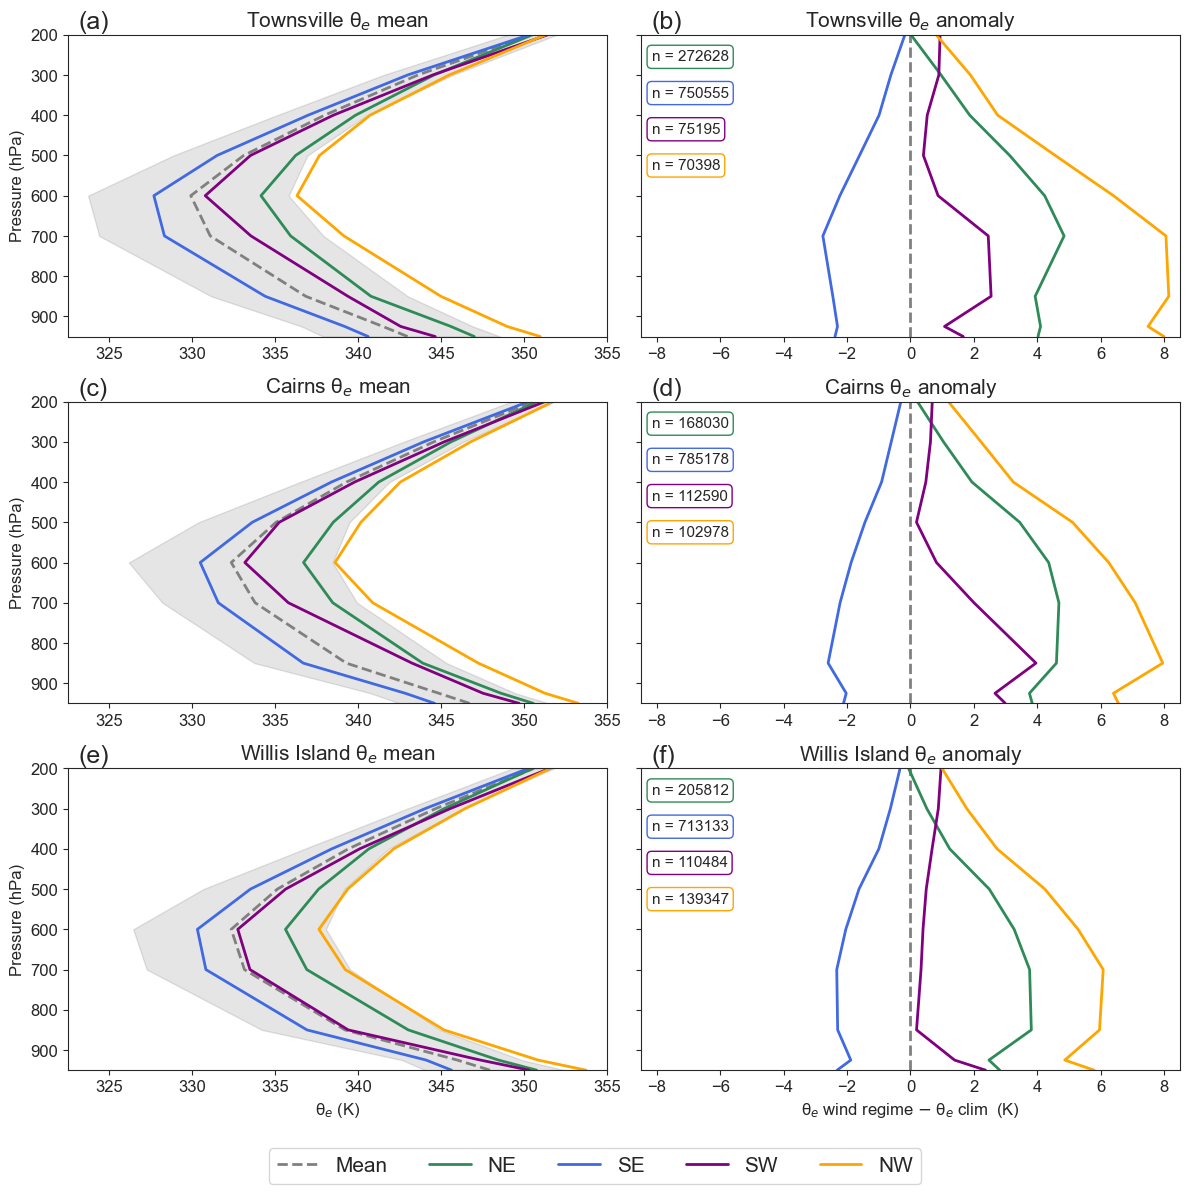

In [15]:
plot_eqpt_mean_anomalies(site)


# Plot diurnal eqpt dependent on wind regime

In [65]:
import string
def plot_hourly_eqpt_on_axes(ax, eqpt_dict, pressure, levels,label_start=0):
    """Plot θₑ hourly regime panels on a given list of axes."""
    titles = ["NW", "NE", "SW", "SE"]
    cmap = "viridis"
    hours = np.arange(0, 24, 1)
    xticks = np.arange(0, 24, 6)
    yticks = np.arange(20000, 100000, 10000)
    yticklabels = ["200", "300", "400", "500", "600", "700", "800", "900"]
    labels = list(string.ascii_lowercase)

    for i, key in enumerate(["eqptNW", "eqptNE", "eqptSW", "eqptSE"]):
        cs = ax[i].contourf(hours, pressure, eqpt_dict[key].T, levels=levels, cmap=cmap)
        ax[i].invert_yaxis()
        ax[i].set_xticks(xticks)
        ax[i].set_yticks(yticks)
        ax[i].set_yticklabels(yticklabels)
        ax[i].set_title(titles[i],fontsize=20)
        ax[i].set_xlabel("Hour (LT)",fontsize=15)
        # Continuous subplot letters
        subplot_label = labels[label_start + i]
        ax[i].text(
            0.00, 1.02,
            f'({subplot_label})',
            transform=ax[i].transAxes,
            fontsize=18,
            # fontweight='bold',
            va='bottom', ha='left'
        )

    return cs  # for colorbar


/jobfs/159640163.gadi-pbs/ipykernel_2193324/131894971.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(h_pad=3.0, rect=[0, 0, 0.9, 1])


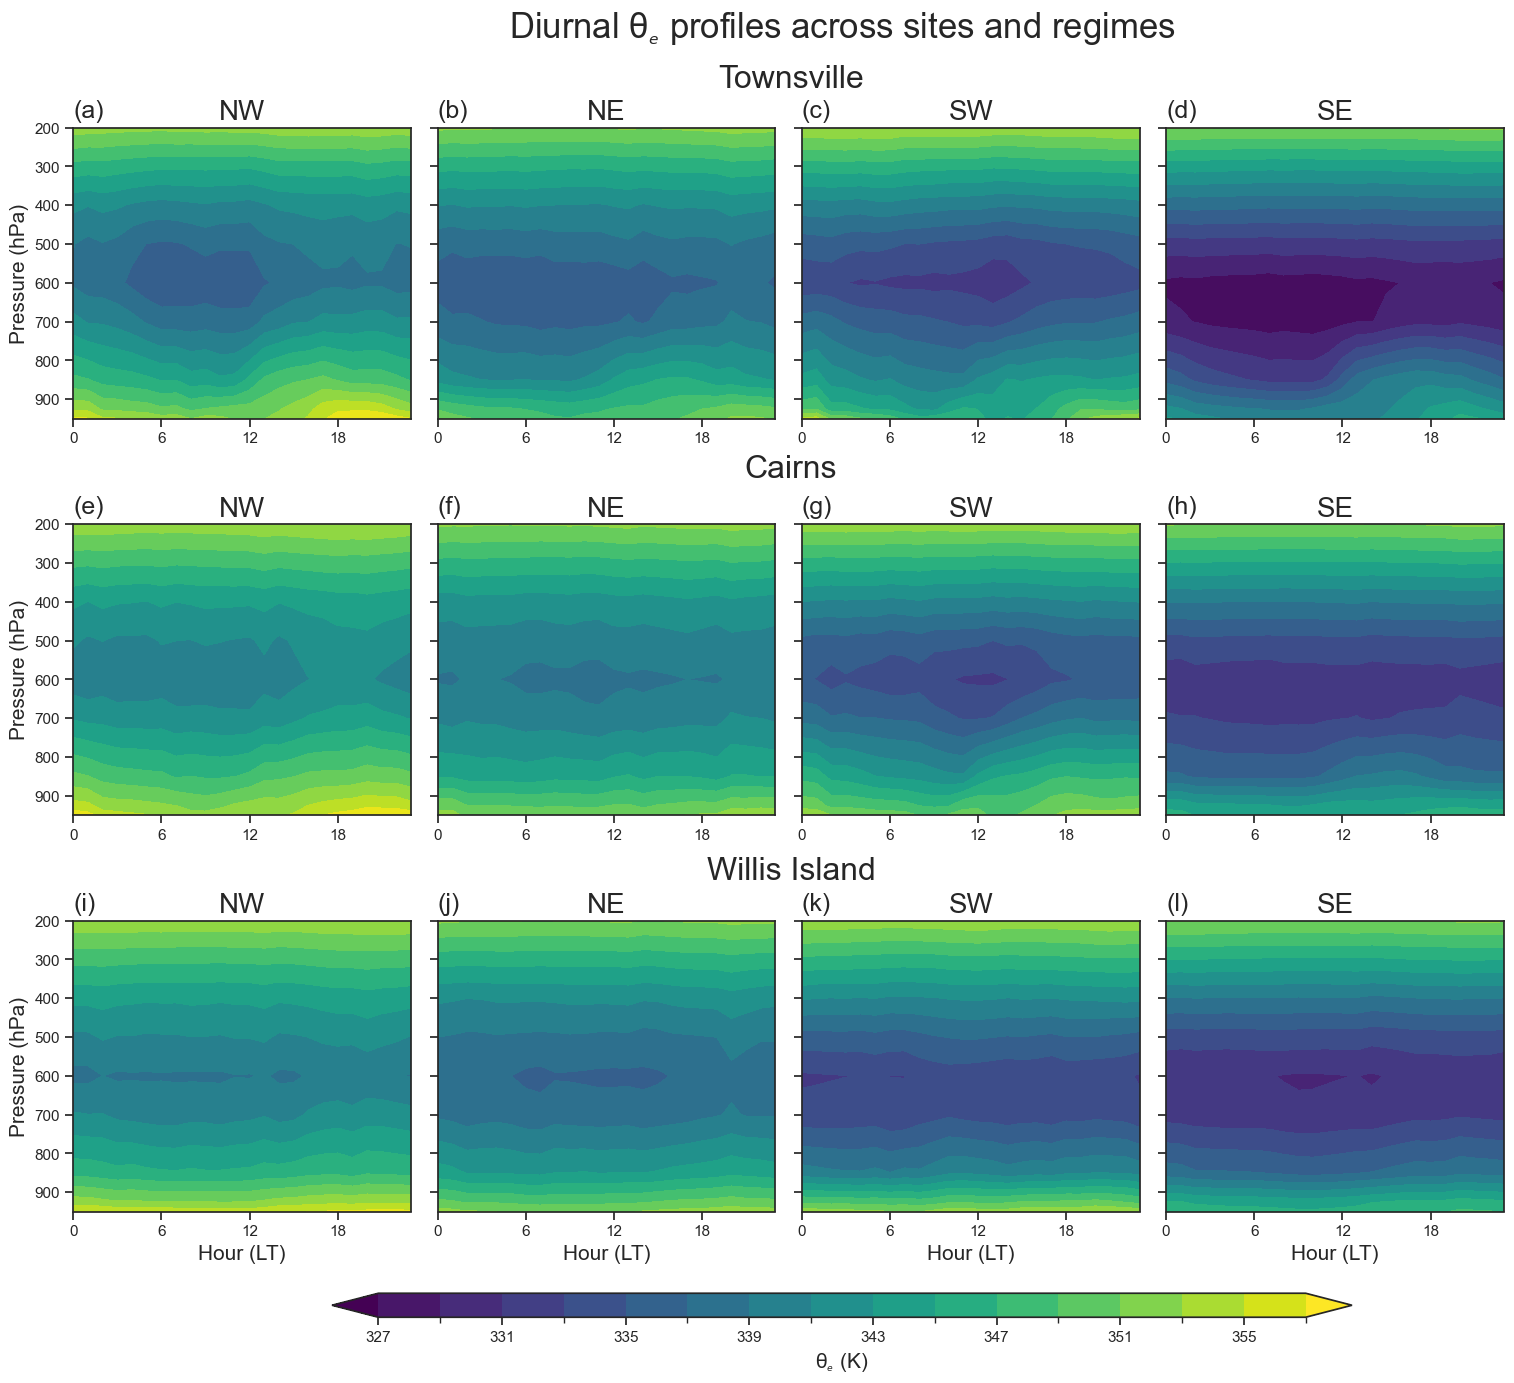

In [67]:
# plot diurnal eqpt
pressure = np.array([95000, 92500, 85000, 70000, 60000, 50000, 40000, 30000, 20000])
levels = np.arange(327, 360, 2)
levels = [327,329,331,333,335,337,339,341,343,345,347,349,351,353,355,357]
sites = {
    "Townsville": {
        'eqpt': np.roll(np.load('/g/data/q90/ac9768/GBR/barra-2/eqpt/eqpt_towns.npy'),shift=1,axis=0),
        'eqptNE': np.roll(np.load('/g/data/q90/ac9768/GBR/barra-2/eqpt/eqpt_NE_towns.npy'),shift=1,axis=0),
        'eqptSE': np.roll(np.load('/g/data/q90/ac9768/GBR/barra-2/eqpt/eqpt_SE_towns.npy'),shift=1,axis=0),
        'eqptSW': np.roll(np.load('/g/data/q90/ac9768/GBR/barra-2/eqpt/eqpt_SW_towns.npy'),shift=1,axis=0),
        'eqptNW': np.roll(np.load('/g/data/q90/ac9768/GBR/barra-2/eqpt/eqpt_NW_towns.npy'),shift=1,axis=0)
    },
    "Cairns": {
        'eqpt': np.roll(np.load('/g/data/q90/ac9768/GBR/barra-2/eqpt/eqpt_cairns.npy'),shift=1,axis=0),
        'eqptNE': np.roll(np.load('/g/data/q90/ac9768/GBR/barra-2/eqpt/eqpt_NE_cairns.npy'),shift=1,axis=0),
        'eqptSE': np.roll(np.load('/g/data/q90/ac9768/GBR/barra-2/eqpt/eqpt_SE_cairns.npy'),shift=1,axis=0),
        'eqptSW': np.roll(np.load('/g/data/q90/ac9768/GBR/barra-2/eqpt/eqpt_SW_cairns.npy'),shift=1,axis=0),
        'eqptNW': np.roll(np.load('/g/data/q90/ac9768/GBR/barra-2/eqpt/eqpt_NW_cairns.npy'),shift=1,axis=0)
    },
    "Willis Island": {
        'eqpt': np.roll(np.load('/g/data/q90/ac9768/GBR/barra-2/eqpt/eqpt_willis.npy'),shift=1,axis=0),
        'eqptNE': np.roll(np.load('/g/data/q90/ac9768/GBR/barra-2/eqpt/eqpt_NE_willis.npy'),shift=1,axis=0),
        'eqptSE': np.roll(np.load('/g/data/q90/ac9768/GBR/barra-2/eqpt/eqpt_SE_willis.npy'),shift=1,axis=0),
        'eqptSW': np.roll(np.load('/g/data/q90/ac9768/GBR/barra-2/eqpt/eqpt_SW_willis.npy'),shift=1,axis=0),
        'eqptNW': np.roll(np.load('/g/data/q90/ac9768/GBR/barra-2/eqpt/eqpt_NW_willis.npy'),shift=1,axis=0)
    }
}

# Create figure with 3×4 subplots (for 3 sites × 4 regimes each)
# sns.set_style("darkgrid")
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(17, 12))
sns.set_theme(style="ticks")

# Plot each site into a row of 4 subplots
for row_idx, (site_name, eqpt_dict) in enumerate(sites.items()):
    ax_row = axs[row_idx]  # Get 4 axes for this site
    ascii_labels = [0,4,8][row_idx]
    plot_hourly_eqpt_on_axes(ax_row, eqpt_dict, pressure, levels,label_start=ascii_labels)

    # ===== Centre site name above the row =====
    # Compute horizontal centre of the 4 subplots in figure coordinates
    row_left = ax_row[0].get_position().x0
    row_right = ax_row[-1].get_position().x1
    row_center = (row_left + row_right) / 2

    # # Add the text in figure coordinates
    # fig.text(row_center, ax_row[0].get_position().y1 + 0.1,  # slightly above top of first axes
    #          site_name,
    #          fontsize=30,
    #          ha='center',)
    #          # va='bottom')  # vertical alignment bottom ensures text sits just above axes

    # y-axis label on leftmost subplot
    ax_row[0].set_ylabel("Pressure (hPa)", fontsize=15)
    # remove y-tick labels from other columns
    for ax in ax_row[1:]:
        ax.set_yticklabels([])

    # Only show x-labels for bottom row
    if row_idx < len(sites) - 1:
        for ax in ax_row:
            ax.set_xlabel("")           # Remove x-label

fig.text(
    0.47, 0.99,  # between top and middle blocks
    r"Townsville",
    ha="center",
    va="bottom",
    fontsize=23,
)
fig.text(
    0.47, 0.665,  # between top and middle blocks
    r"Cairns",
    ha="center",
    va="bottom",
    fontsize=23,
)

fig.text(
    0.47, 0.33,  # above bottom block
    r"Willis Island",
    ha="center",
    va="bottom",
    fontsize=23,
)

# Shared colorbar
cbar_ax = fig.add_axes([0.2, -0.03, 0.6, 0.02])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap="viridis")
cmap = mpl.cm.viridis
norm = mpl.colors.BoundaryNorm(levels, cmap.N, extend='both')
sm.set_array(levels)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap), cax=cbar_ax,orientation='horizontal')
cbar.set_label(label='θ$_{\u2091}$ (K)',fontsize=15)
# plt.tight_layout(h_pad=1.9,rect=[0, 0, 0.9, 1])
plt.tight_layout(h_pad=3.0, rect=[0, 0, 0.9, 1])
plt.suptitle("Diurnal θ$_{\u2091}$ profiles across sites and regimes", fontsize=25, y=1.06)
plt.show()
fig.savefig('/home/563/ac9768/GBR/scripts/Paper_figures/f05.png', bbox_inches='tight', dpi=300)

# 1979-2023 climatology

In [7]:
barra_towns = xr.open_dataset("/g/data/q90/ac9768/GBR/barra-2/barra-2_850hPa-winds_towns.nc", engine="h5netcdf",chunks="auto").sel(time=slice('1979-01-01T00:00:00.000000000','2023-05-01T00:00:00.000000000'))
barra_cairns = xr.open_dataset("/g/data/q90/ac9768/GBR/barra-2/barra-2_850hPa-winds_cairns.nc", engine="h5netcdf",chunks="auto").sel(time=slice('1979-01-01T00:00:00.000000000','2023-05-01T00:00:00.000000000'))
barra_willis = xr.open_dataset("/g/data/q90/ac9768/GBR/barra-2/barra-2_850hPa-winds_willis.nc", engine="h5netcdf",chunks="auto").sel(time=slice('1979-01-01T00:00:00.000000000','2023-05-01T00:00:00.000000000'))
barra_towns_eqpt = xr.open_dataset('/g/data/q90/ac9768/GBR/barra-2/barra-2_eqpt-ds_towns.nc').sel(time=slice('1979-01-01T00:00:00.000000000','2023-05-01T00:00:00.000000000'))
barra_cairns_eqpt = xr.open_dataset('/g/data/q90/ac9768/GBR/barra-2/barra-2_eqpt-ds_cairns.nc').sel(time=slice('1979-01-01T00:00:00.000000000','2023-05-01T00:00:00.000000000'))
barra_willis_eqpt = xr.open_dataset('/g/data/q90/ac9768/GBR/barra-2/barra-2_eqpt-ds_willis.nc').sel(time=slice('1979-01-01T00:00:00.000000000','2023-05-01T00:00:00.000000000'))

In [7]:
def UTC_to_LST(ds, timezone): # longitude
    ds = ds.copy()
    # Convert to pandas datetime in UTC
    time_objects_utc = pd.to_datetime(ds['time'].values).tz_localize('UTC')
    
    # Convert to local standard time using pytz
    local_timezone = pytz.timezone(timezone)
    time_objects_local = time_objects_utc.tz_convert(local_timezone).tz_localize(None)

    ds['time'] = time_objects_local#.tz_localize(None)
    return ds

In [9]:
def wind_times(barra_regime_ds: xr.Dataset):    
    winds = barra_regime_ds.wind_dir.compute()
    ne = winds[(winds>=0)&(winds<=90)].time.values
    se = winds[(winds>90)&(winds<=180)].time.values
    sw = winds[(winds>180)&(winds<=270)].time.values
    nw = winds[(winds>270)&(winds<=360)].time.values
    return ne,se,sw,nw
ne_towns,se_towns,sw_towns,nw_towns = wind_times(barra_towns)
ne_cairns,se_cairns,sw_cairns,nw_cairns = wind_times(barra_cairns)
ne_willis,se_willis,sw_willis,nw_willis = wind_times(barra_willis)

In [14]:
print(len(ne_willis),len(se_willis),len(sw_willis),len(nw_willis))

22868 79237 12276 15483


In [16]:
def plot_hourly_eqpt_on_axes(ax, eqpt_dict, pressure, levels):
    """Plot θₑ hourly regime panels on a given list of axes."""
    titles = ["NW", "NE", "SW", "SE"]
    cmap = "viridis"
    hours = np.arange(0, 24, 1)
    xticks = np.arange(0, 24, 6)
    yticks = np.arange(200, 1000, 100)
    yticklabels = ["200", "300", "400", "500", "600", "700", "800", "900"]

    for i, key in enumerate(["eqptNW", "eqptNE", "eqptSW", "eqptSE"]):
        cs = ax[i].contourf(hours, pressure, eqpt_dict[key], levels=levels, cmap=cmap)
        ax[i].invert_yaxis()
        ax[i].set_xticks(xticks)
        ax[i].set_yticks(yticks)
        ax[i].set_yticklabels(yticklabels)
        ax[i].set_title(titles[i],fontsize=20)
        ax[i].set_xlabel("Hour (LT)",fontsize=15)
    return cs  # for colorbar

In [17]:
sites = {
    "Townsville": {
        'eqpt': np.roll(np.load('/home/563/ac9768/GBR/barra-2/eqpt/eqpt_towns.npy'),shift=1,axis=0),
        'eqptNE': UTC_to_LST(barra_towns_eqpt.eqpt.sel(time=ne_towns),'Australia/Sydney').groupby('time.hour').mean('time'),
        'eqptSE': UTC_to_LST(barra_towns_eqpt.eqpt.sel(time=se_towns),'Australia/Sydney').groupby('time.hour').mean('time'),
        'eqptSW': UTC_to_LST(barra_towns_eqpt.eqpt.sel(time=sw_towns),'Australia/Sydney').groupby('time.hour').mean('time'),
        'eqptNW': UTC_to_LST(barra_towns_eqpt.eqpt.sel(time=nw_towns),'Australia/Sydney').groupby('time.hour').mean('time')
    },
    "Cairns": {
        'eqpt': np.roll(np.load('/home/563/ac9768/GBR/barra-2/eqpt/eqpt_cairns.npy'),shift=1,axis=0),
        'eqptNE': UTC_to_LST(barra_cairns_eqpt.eqpt.sel(time=ne_cairns),'Australia/Sydney').groupby('time.hour').mean('time'),
        'eqptSE': UTC_to_LST(barra_cairns_eqpt.eqpt.sel(time=se_cairns),'Australia/Sydney').groupby('time.hour').mean('time'),
        'eqptSW': UTC_to_LST(barra_cairns_eqpt.eqpt.sel(time=sw_cairns),'Australia/Sydney').groupby('time.hour').mean('time'),
        'eqptNW': UTC_to_LST(barra_cairns_eqpt.eqpt.sel(time=nw_cairns),'Australia/Sydney').groupby('time.hour').mean('time')
    },
    "Willis Island": {
        'eqpt': np.roll(np.load('/home/563/ac9768/GBR/barra-2/eqpt/eqpt_willis.npy'),shift=1,axis=0),
        'eqptNE': UTC_to_LST(barra_willis_eqpt.eqpt.sel(time=ne_willis),'Australia/Sydney').groupby('time.hour').mean('time'),
        'eqptSE': UTC_to_LST(barra_willis_eqpt.eqpt.sel(time=se_willis),'Australia/Sydney').groupby('time.hour').mean('time'),
        'eqptSW': UTC_to_LST(barra_willis_eqpt.eqpt.sel(time=sw_willis),'Australia/Sydney').groupby('time.hour').mean('time'),
        'eqptNW': UTC_to_LST(barra_willis_eqpt.eqpt.sel(time=nw_willis),'Australia/Sydney').groupby('time.hour').mean('time')
    }
}

FileNotFoundError: [Errno 2] No such file or directory: '/home/563/ac9768/GBR/barra-2/eqpt/eqpt_towns.npy'

In [18]:
sites["Cairns"]["eqptNE"].sel(pressure=850)
([341.06862193, 340.60598308, 340.02459096, 339.71996787,
       339.52353101, 339.31916546, 339.23948676, 338.86101475,
       338.72659216, 338.65265408, 338.88586131, 339.72720754,
       340.99516846, 341.61387355, 341.91260901, 342.26398986,
       342.42551303, 342.4886772 , 342.4903668 , 342.4908186 ,
       342.66712837, 342.32244053, 341.94078021, 341.54790317])

([343.91982836, 343.7928892 , 343.46418276, 343.3555917 ,
       343.16973303, 342.99493828, 342.88118122, 342.70005596,
       342.77287095, 342.71362731, 342.84995599, 343.30975397,
       344.06955275, 344.46324778, 344.39691695, 344.58625197,
       344.7984931 , 344.87123875, 344.80159547, 344.61444555,
       344.95461258, 344.79514361, 344.52075901, 344.14130787])

NameError: name 'sites' is not defined

/jobfs/143243899.gadi-pbs/ipykernel_3688390/3078293868.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(h_pad=1.9,rect=[0, 0, 0.9, 1])


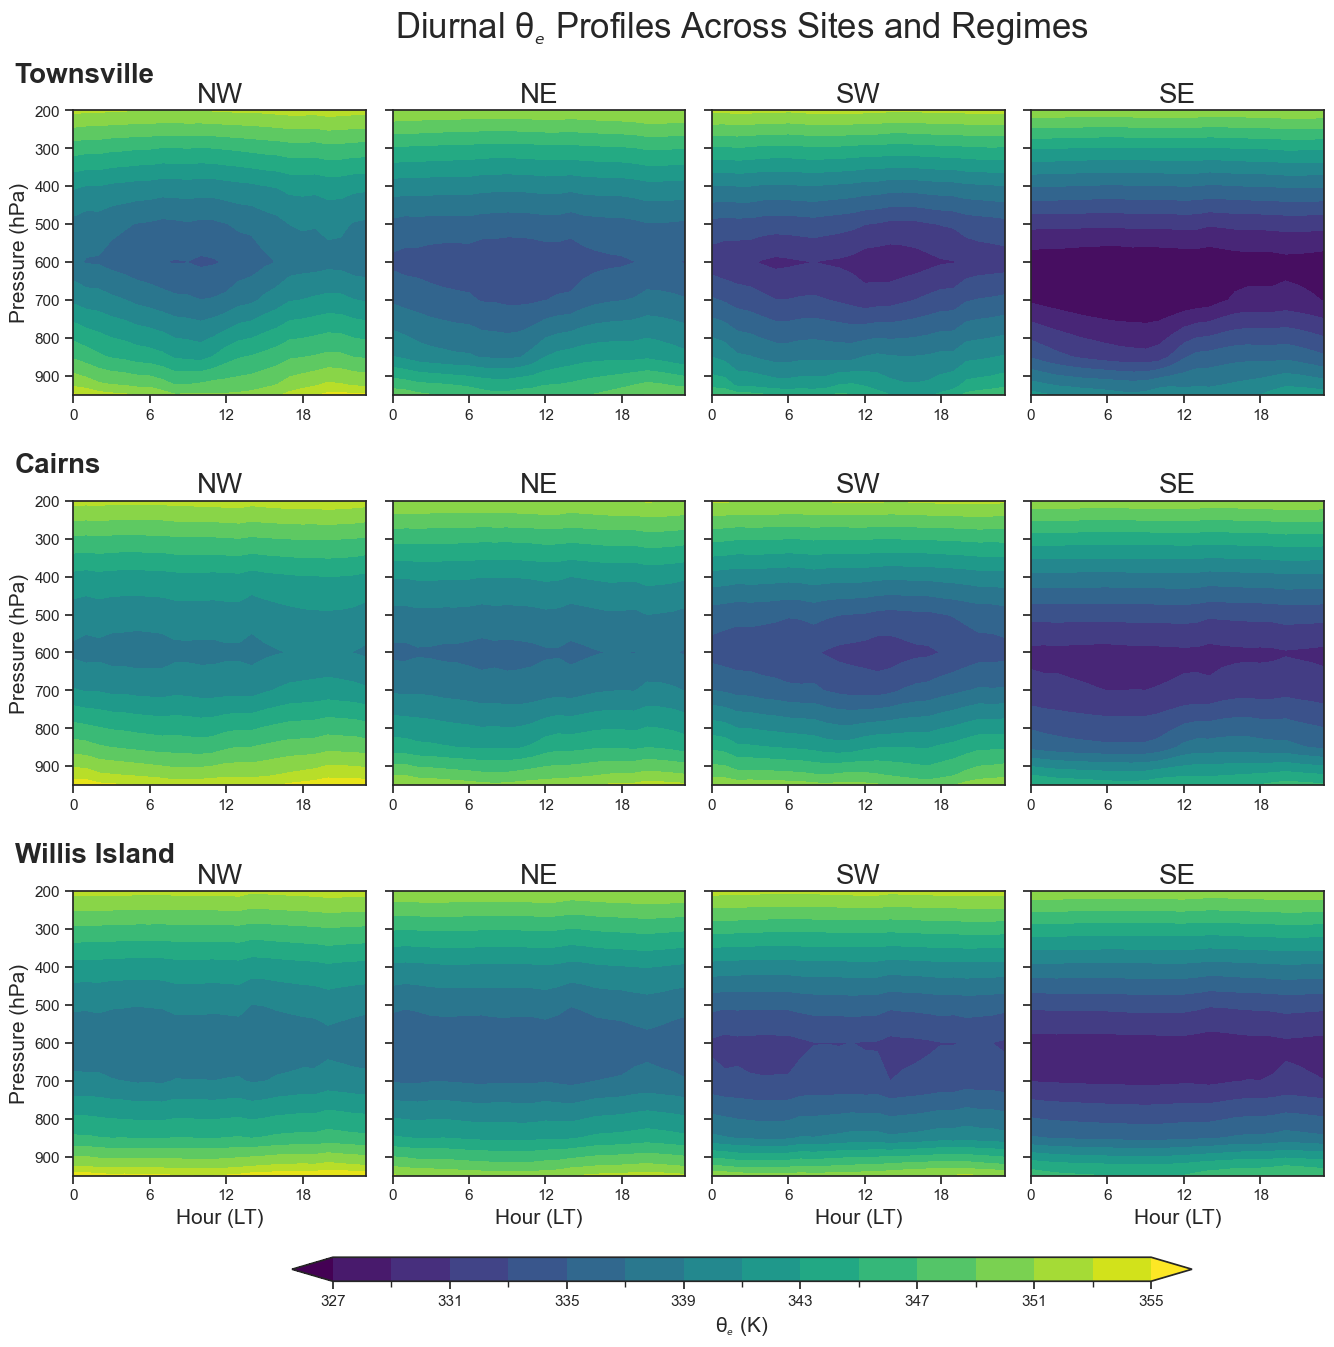

In [123]:
pressure = barra_towns_eqpt.pressure.values
levels = np.arange(327, 360, 2)
levels = [327,329,331,333,335,337,339,341,343,345,347,349,351,353,355]

# Create figure with 3×4 subplots (for 3 sites × 4 regimes each)
# sns.set_style("darkgrid")
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 12))
sns.set_theme(style="ticks")

# Plot each site into a row of 4 subplots
for row_idx, (site_name, eqpt_dict) in enumerate(sites.items()):
    ax_row = axs[row_idx]  # Get 4 axes for this site
    plot_hourly_eqpt_on_axes(ax_row, eqpt_dict, pressure, levels)
    ax_row[0].text(-0.2, 1.1, site_name, transform=ax_row[0].transAxes,
                   fontsize=20, fontweight='bold')
    ax_row[0].set_ylabel("Pressure (hPa)",fontsize=15)
    ax_row[1].set_yticklabels([])
    ax_row[2].set_yticklabels([])
    ax_row[3].set_yticklabels([])

    # Only show x-labels for bottom row
    if row_idx < len(sites) - 1:
        for ax in ax_row:
            ax.set_xlabel("")           # Remove x-label

# Shared colorbar
cbar_ax = fig.add_axes([0.2, -0.03, 0.6, 0.02])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap="viridis")
cmap = mpl.cm.viridis
norm = mpl.colors.BoundaryNorm(levels, cmap.N, extend='both')
sm.set_array(levels)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap), cax=cbar_ax,orientation='horizontal')
cbar.set_label(label='θ$_{\u2091}$ (K)',fontsize=15)
plt.tight_layout(h_pad=1.9,rect=[0, 0, 0.9, 1])
plt.suptitle("Diurnal θ$_{\u2091}$ Profiles Across Sites and Regimes", fontsize=25, y=1.03)
plt.show()
fig.savefig('/home/563/ac9768/GBR/plots/eqpt_diurnal_cycle-1979_2023.png', bbox_inches='tight', dpi=400)